In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import itertools
import collections

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 자산명과 티커
asset_dict = {
    "WTI":    "CL=F",    # Crude Oil WTI
    "USD_KRW":"KRW=X",   # USD/KRW exchange rate
    "Gold":   "GC=F",    # Gold Futures
    "S&P500": "^GSPC",   # S&P 500 Index
    "US10Y":  "^TNX",    # 10Y Treasury Yield
    "VIX":    "^VIX",    # Volatility Index
    "KOSPI":  "^KS11"    # KOSPI Index
}

start_date = "2015-01-02"
end_date = "2025-05-15"
data_frames = {}
asset_name= ["WTI", "USD_KRW", "Gold", "S&P500", "US10Y", "VIX", "KOSPI"]

# 데이터 다운로드 및 변환
for name, ticker in asset_dict.items():
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    if 'Close' not in df.columns:
        raise ValueError(f"Ticker {ticker} has no 'Close'")
    close_series = df['Close']
    # DataFrame이 반환되는 상황을 대비해
    if isinstance(close_series, pd.DataFrame):
        close_series = close_series.iloc[:, 0]
    # 1차원 Series로 강제 변환
    series = pd.Series(close_series.values.ravel(), index=close_series.index, name=name)
    data_frames[name] = series

# 병합 및 결측값 보간
combined_df = pd.concat(data_frames.values(), axis=1, join='outer')
combined_df.sort_index(inplace=True)
combined_df.fillna(method='ffill', inplace=True)  # 결측치 전방 채움

# [0, 1] 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = pd.DataFrame(
    scaler.fit_transform(combined_df),
    index=combined_df.index,
    columns=combined_df.columns
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-2-366d28b76ac7>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df.fillna(method='ffill', inplace=True)  # 결측치 전방 채움


In [ ]:
# Latent Encoder Module
class AssetEncoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return h_n[-1]

class KospiLatentModel(nn.Module):
    def __init__(self, hidden_size=128):
        super().__init__()
        self.hidden_size = hidden_size
        self.asset_encoders = nn.ModuleList([AssetEncoder(1, hidden_size) for _ in range(6)])
        self.kospi_encoder = AssetEncoder(1, hidden_size)
        self.weighten = nn.Linear(hidden_size * 7, 7)
        self.fc = nn.Linear(hidden_size * 7, hidden_size)
        self.decoder = nn.Linear(hidden_size, 1)

    def forward(self, other_series_list, kospi_series):
        asset_reprs = [enc(x).unsqueeze(1) for enc, x in zip(self.asset_encoders, other_series_list)]
        kospi_repr = self.kospi_encoder(kospi_series).unsqueeze(1)
        all_reprs = torch.cat(asset_reprs + [kospi_repr], dim=1)

        concatenated = all_reprs.view(-1, 7 * self.hidden_size)
        a_weights = torch.softmax(self.weighten(concatenated), dim=1).unsqueeze(2)

        weighted_reprs = all_reprs * a_weights
        fused_repr = weighted_reprs.view(-1, 7 * self.hidden_size)
        latent_feature = self.fc(fused_repr)
        prediction = self.decoder(latent_feature)
        return latent_feature, a_weights.squeeze(2), prediction, weighted_reprs



# a_weight 추출

In [ ]:
# Data Preparation
seq_len = 60
X, Y = [], []
for i in range(len(scaled_df) - seq_len):
    window = scaled_df.iloc[i:i+seq_len]
    X.append(window.drop(columns="KOSPI").values)
    Y.append(window["KOSPI"].values.reshape(-1, 1))

X = torch.tensor(X, dtype=torch.float32).to(device)
Y = torch.tensor(Y, dtype=torch.float32).to(device)

<ipython-input-4-39ed5475b929>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(X, dtype=torch.float32).to(device)


In [ ]:
# Training

num_epochs = 150

model = KospiLatentModel(hidden_size=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    asset_inputs = [X[:,:,i:i+1] for i in range(6)]
    kospi_series = Y

    latent_vector, a_weights, prediction, weighted_reprs = model(
        asset_inputs, kospi_series
    )
    print("pre", prediction)
    print("Y", Y[:, -1,   :])
    loss = criterion(prediction, Y[:, -1,   :])
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item():.4f}")



pre tensor([[-0.0457],
        [-0.0457],
        [-0.0457],
        ...,
        [-0.0455],
        [-0.0455],
        [-0.0455]], device='cuda:0', grad_fn=<AddmmBackward0>)
Y tensor([[0.3058],
        [0.3043],
        [0.3098],
        ...,
        [0.6060],
        [0.6223],
        [0.6229]], device='cuda:0')
Epoch 1/150, Training Loss: 0.3363
pre tensor([[-0.0096],
        [-0.0096],
        [-0.0096],
        ...,
        [-0.0062],
        [-0.0062],
        [-0.0062]], device='cuda:0', grad_fn=<AddmmBackward0>)
Y tensor([[0.3058],
        [0.3043],
        [0.3098],
        ...,
        [0.6060],
        [0.6223],
        [0.6229]], device='cuda:0')
Epoch 2/150, Training Loss: 0.2965
pre tensor([[0.0279],
        [0.0279],
        [0.0279],
        ...,
        [0.0347],
        [0.0347],
        [0.0347]], device='cuda:0', grad_fn=<AddmmBackward0>)
Y tensor([[0.3058],
        [0.3043],
        [0.3098],
        ...,
        [0.6060],
        [0.6223],
        [0.6229]], devic

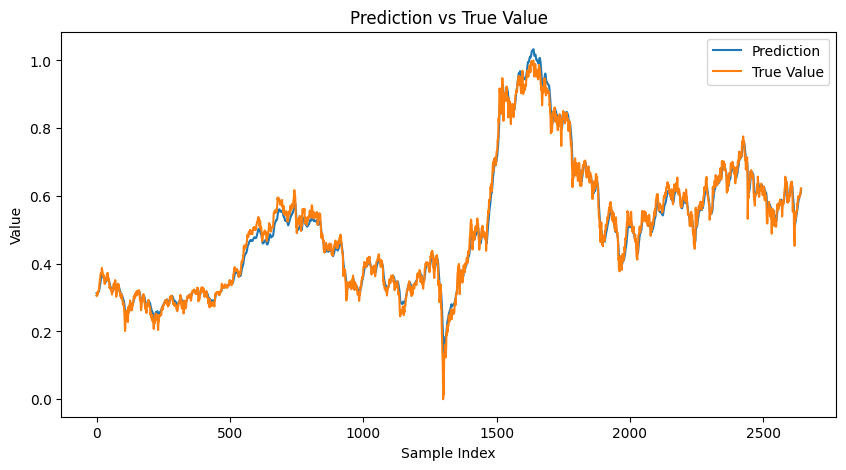

In [ ]:
model.eval()
with torch.no_grad():
    asset_inputs = [X[:, :, i:i+1] for i in range(6)]
    kospi_series = Y
    latent_vector, a_weights, prediction, weighted_reprs = model(asset_inputs, kospi_series)

    # prediction: [batch_size, 1] or [batch_size]
    # 실제값: Y[:, -1, :] -> [batch_size, 1] or [batch_size]
    pred_np = prediction.cpu().numpy().squeeze()
    ytrue_np = Y[:, -1, :].cpu().numpy().squeeze()

# 그래프
plt.figure(figsize=(10,5))
plt.plot(pred_np, label='Prediction')
plt.plot(ytrue_np, label='True Value')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Prediction vs True Value')
plt.legend()
plt.show()


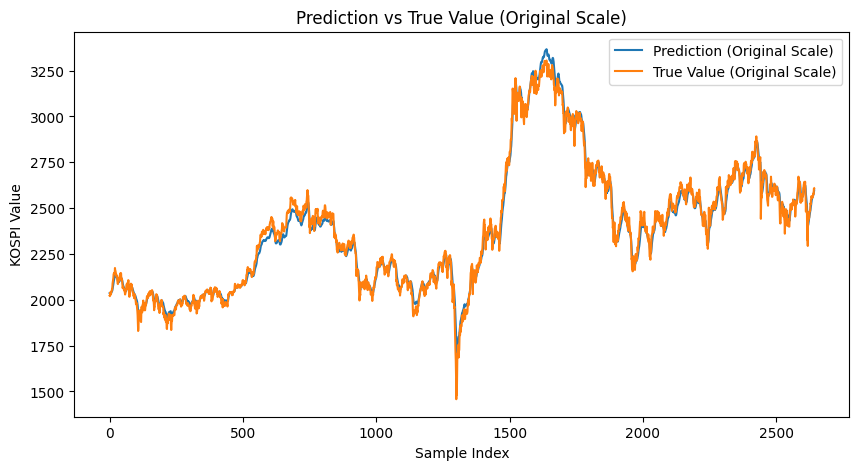

In [ ]:
# KOSPI 열의 index를 찾기 (예: combined_df.columns)
kospi_col_idx = list(combined_df.columns).index('KOSPI')

# [0, 1] 스케일 값을 다시 원래 값으로 복원
# pred_np, ytrue_np shape: (batch_size,)
# MinMaxScaler는 2D 입력 필요 (batch_size, n_features)
pred_inv = scaler.inverse_transform(
    np.concatenate([
        np.zeros((len(pred_np), kospi_col_idx)),    # 앞에 더미 컬럼
        pred_np.reshape(-1, 1),                     # KOSPI 예측
        np.zeros((len(pred_np), len(combined_df.columns) - kospi_col_idx - 1))  # 뒤에 더미 컬럼
    ], axis=1)
)[:, kospi_col_idx]

ytrue_inv = scaler.inverse_transform(
    np.concatenate([
        np.zeros((len(ytrue_np), kospi_col_idx)),
        ytrue_np.reshape(-1, 1),
        np.zeros((len(ytrue_np), len(combined_df.columns) - kospi_col_idx - 1))
    ], axis=1)
)[:, kospi_col_idx]

# 그래프
plt.figure(figsize=(10,5))
plt.plot(pred_inv, label='Prediction (Original Scale)')
plt.plot(ytrue_inv, label='True Value (Original Scale)')
plt.xlabel('Sample Index')
plt.ylabel('KOSPI Value')
plt.title('Prediction vs True Value (Original Scale)')
plt.legend()
plt.show()


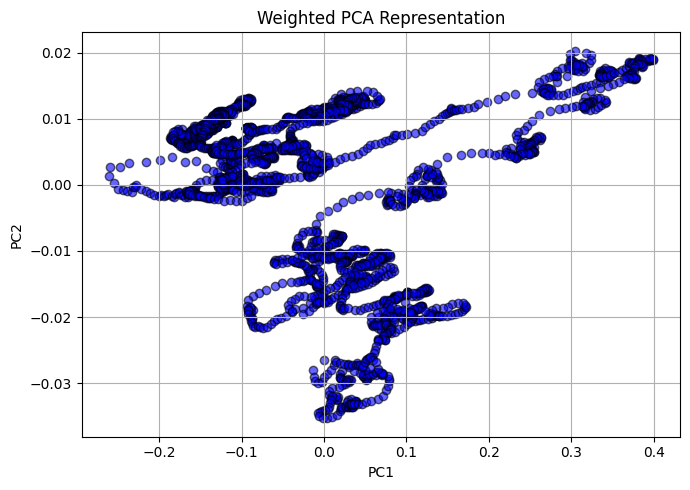

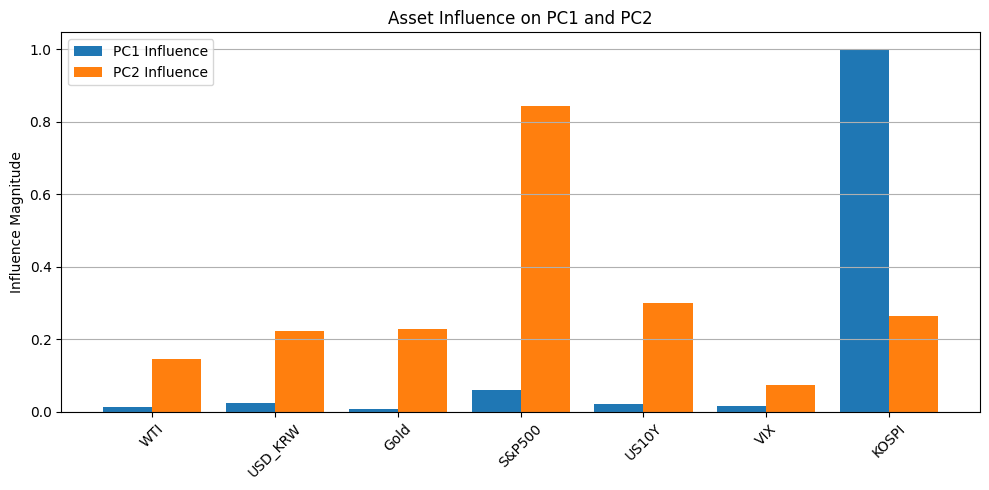

In [ ]:
# Visualization
def Visualize(latent_vectors, a_weights, weighted_reprs, title="Latent Feature PCA"):


    # PCA on weighted representations
    batch_size, num_assets, hidden_size = weighted_reprs.size()
    weighted_np = weighted_reprs.view(batch_size, num_assets * hidden_size).detach().cpu().numpy()

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(weighted_np)

    # Plot PCA scatter
    plt.figure(figsize=(7, 5))
    plt.scatter(reduced[:, 0], reduced[:, 1], c='blue', alpha=0.6, edgecolors='k')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    loadings = pca.components_.reshape(2, num_assets, hidden_size)
    asset_pc1 = np.linalg.norm(loadings[0], axis=1)
    asset_pc2 = np.linalg.norm(loadings[1], axis=1)

    # Asset influence by PC1 and PC2
    plt.figure(figsize=(10,5))
    idx = np.arange(len(asset_name))
    plt.bar(idx - 0.2, asset_pc1, width=0.4, label='PC1 Influence')
    plt.bar(idx + 0.2, asset_pc2, width=0.4, label='PC2 Influence')
    plt.xticks(idx, asset_name, rotation=45)
    plt.ylabel("Influence Magnitude")
    plt.title("Asset Influence on PC1 and PC2")
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


# Execute visualization
Visualize(latent_vector, a_weights, weighted_reprs,
          title="Weighted PCA Representation")


In [ ]:
# 안전 z-score 함수
def safe_zscore(arr):
    arr = np.asarray(arr).astype(float)
    if np.any(np.isnan(arr)):
        return np.zeros_like(arr)
    std = arr.std()
    if std == 0 or np.isnan(std):
        return np.zeros_like(arr)
    return (arr - arr.mean()) / std

# AutoEncoder 정의
class Autoencoder(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=16, latent_dim=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


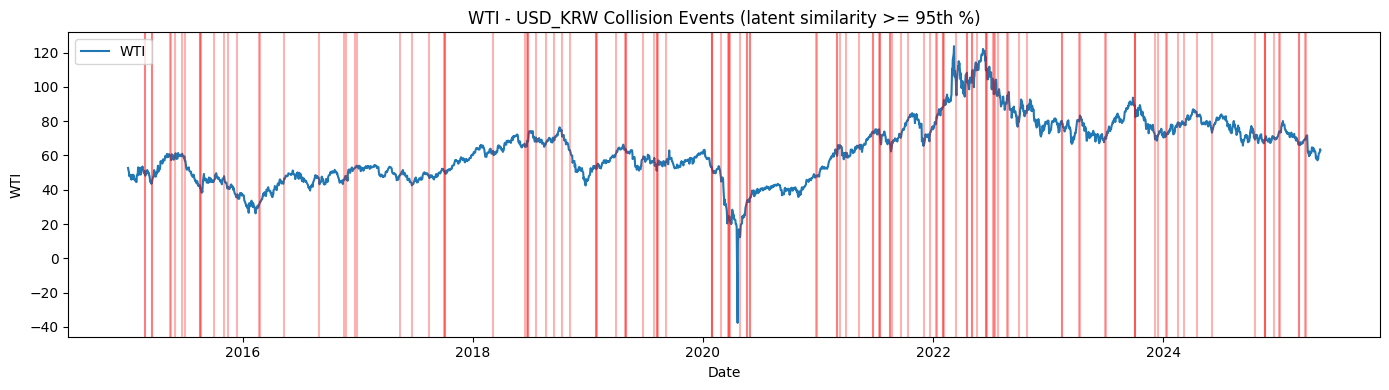

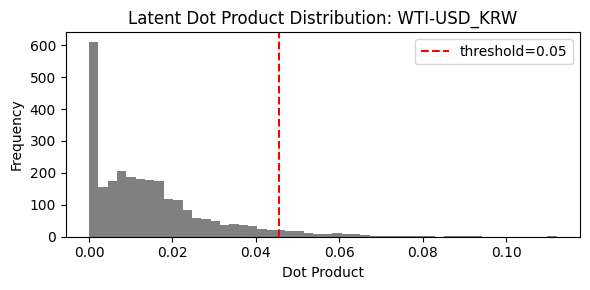

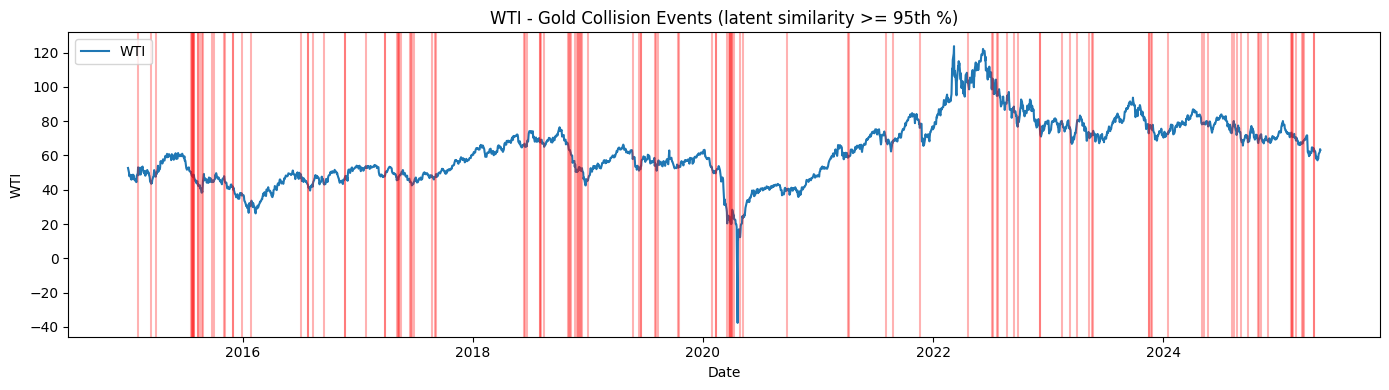

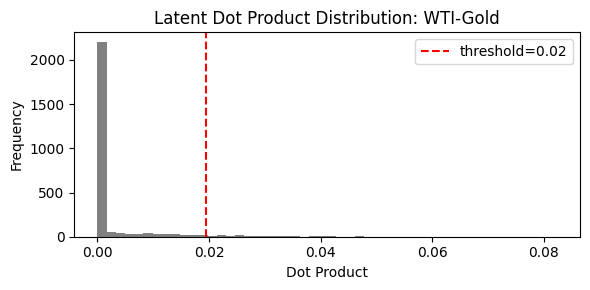

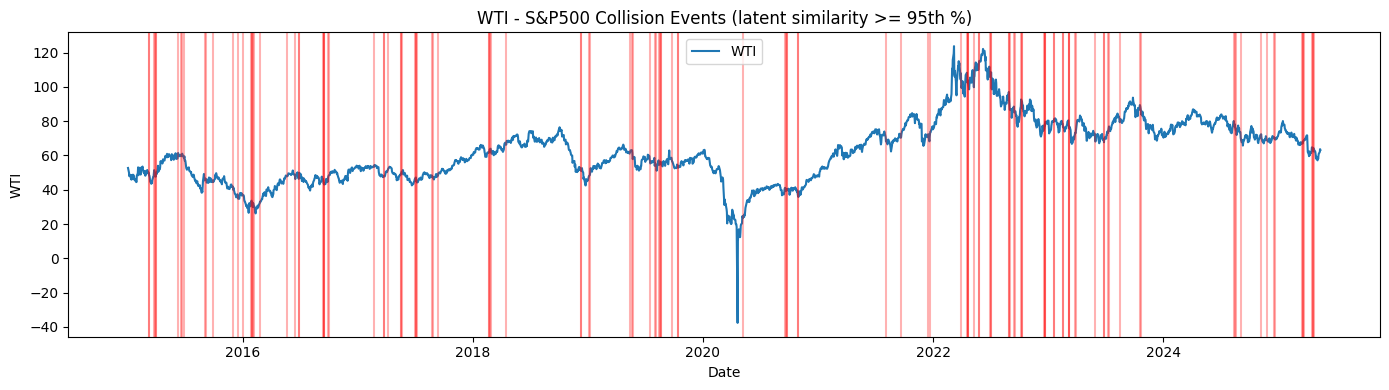

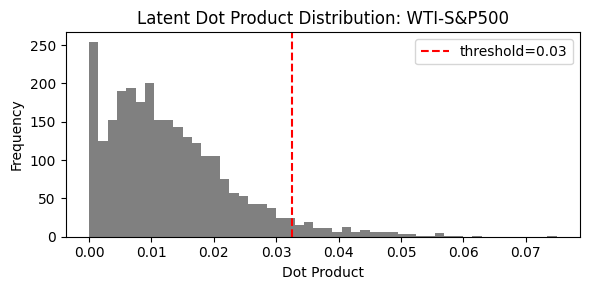

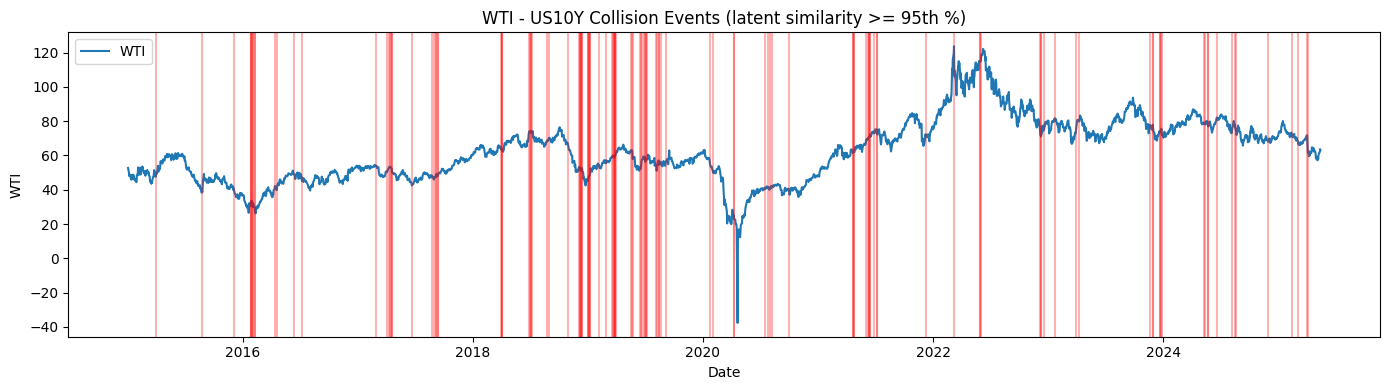

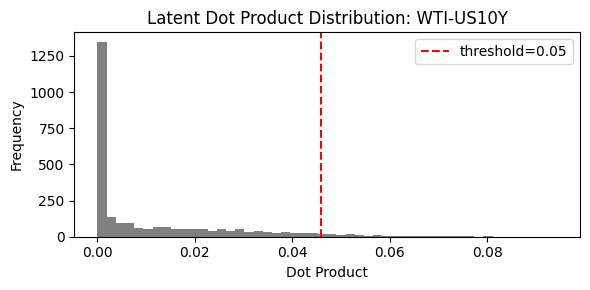

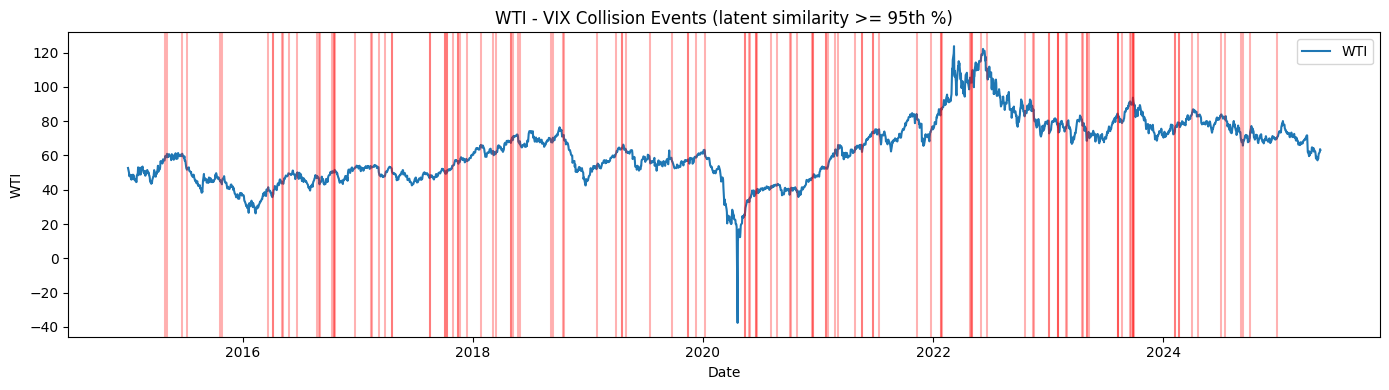

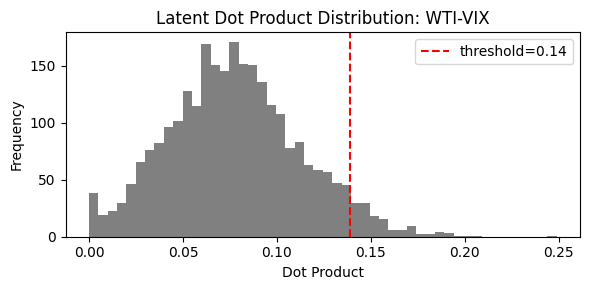

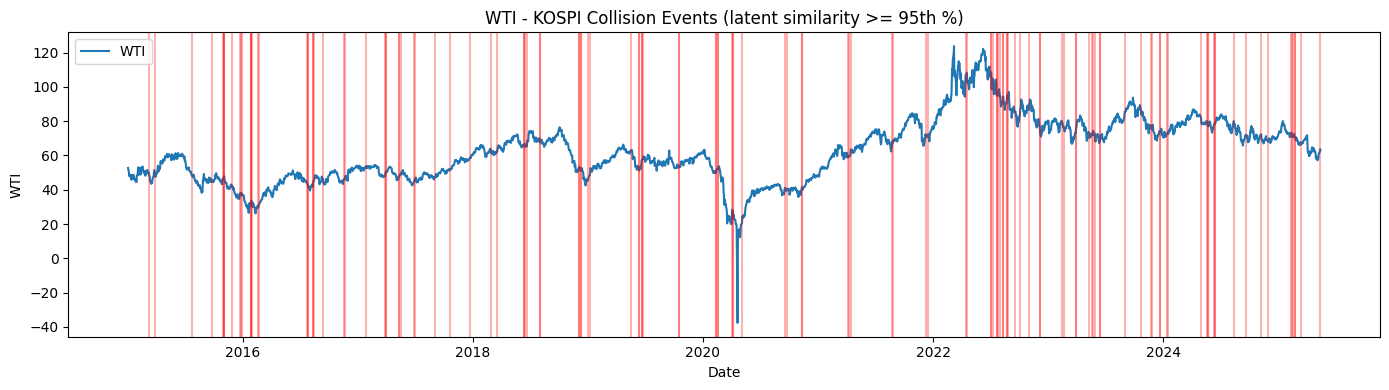

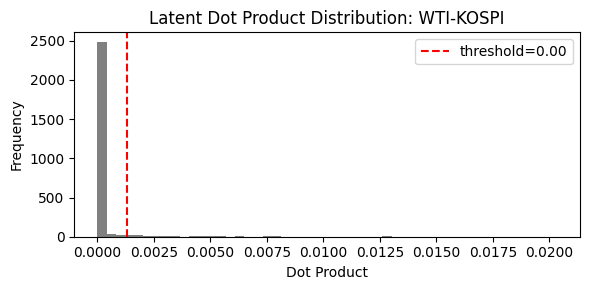

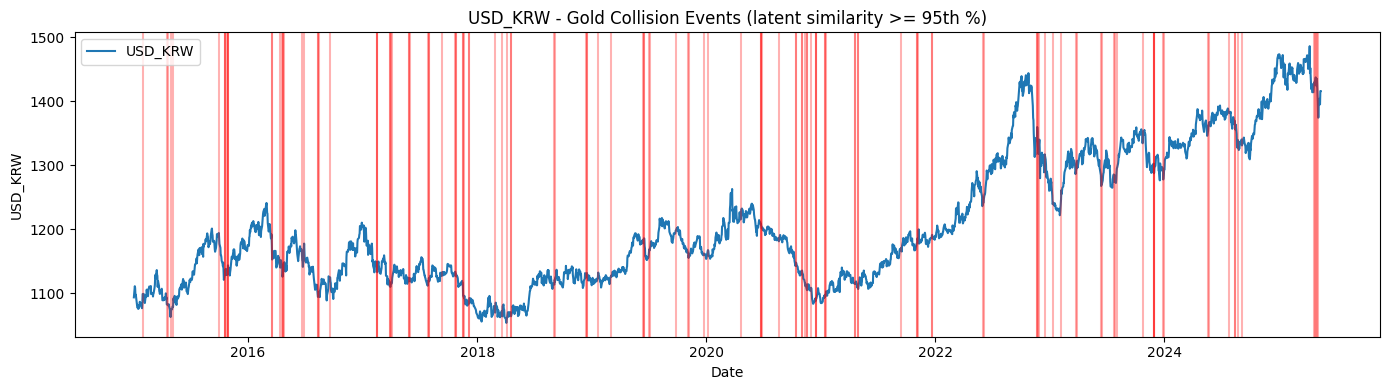

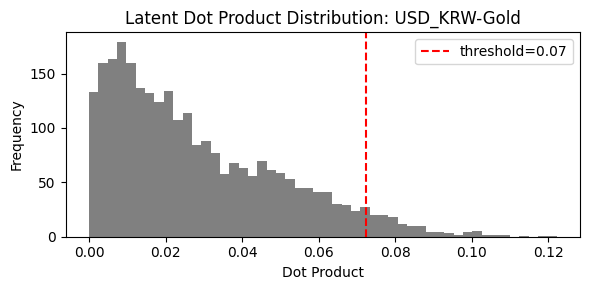

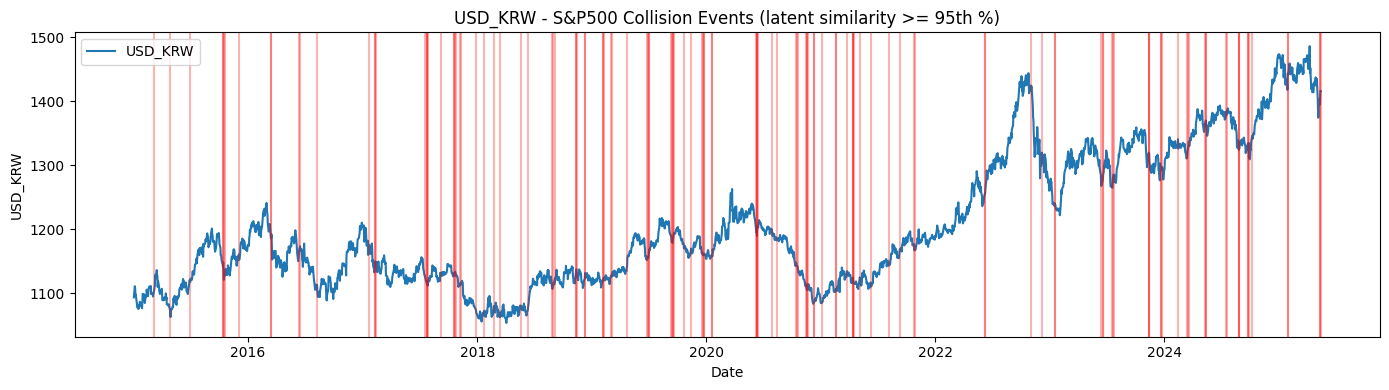

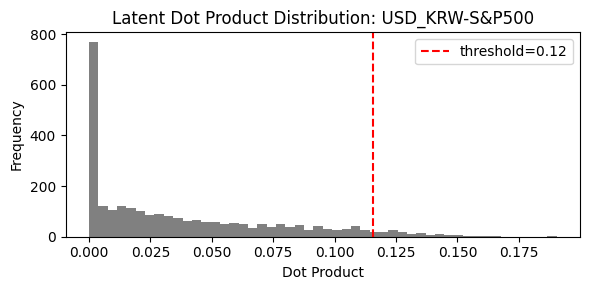

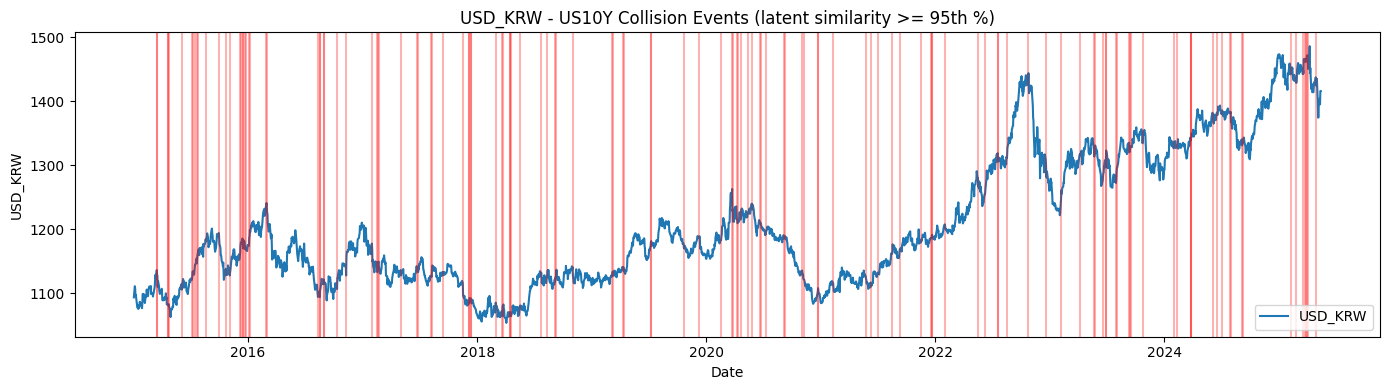

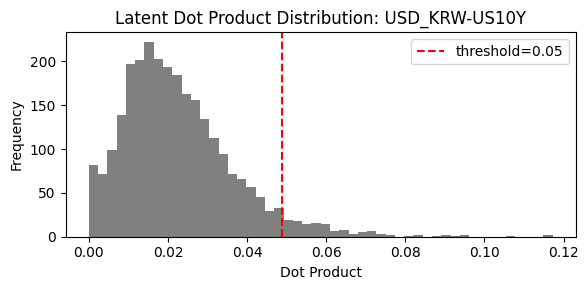

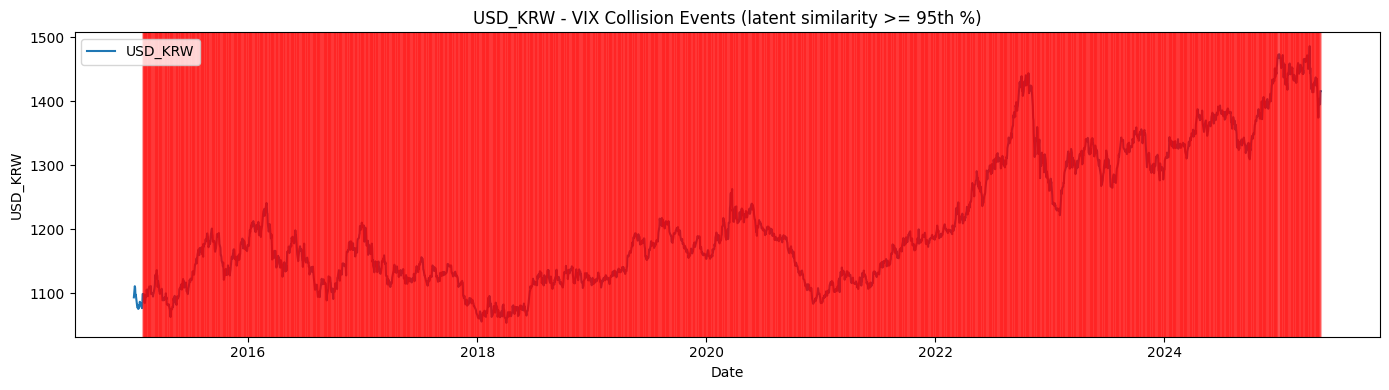

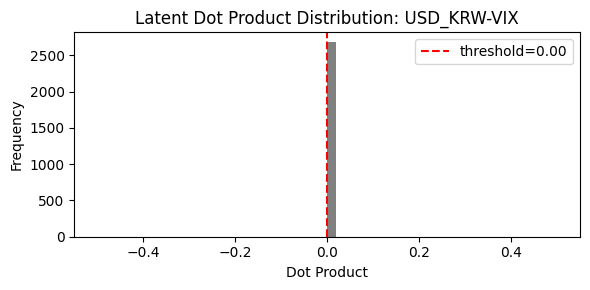

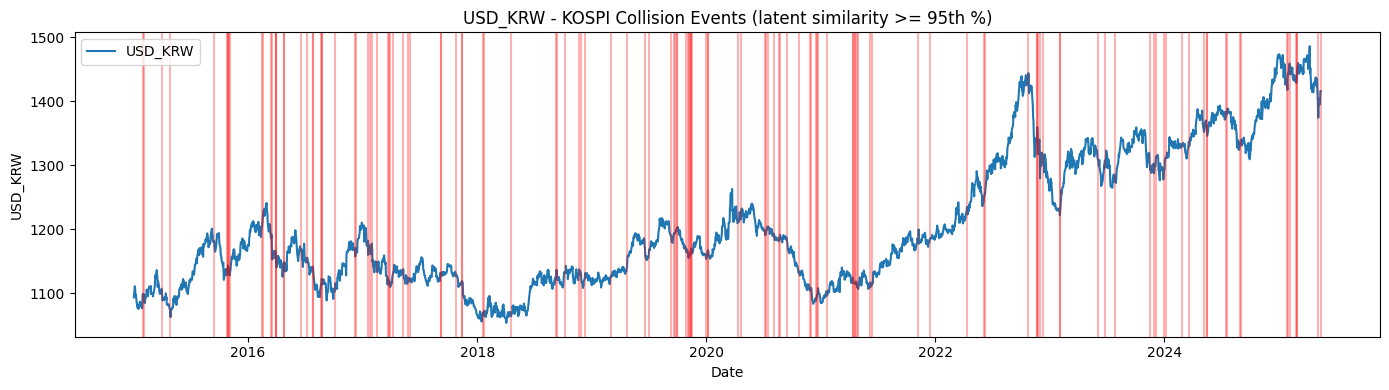

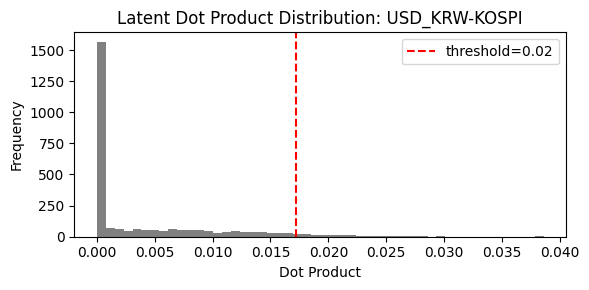

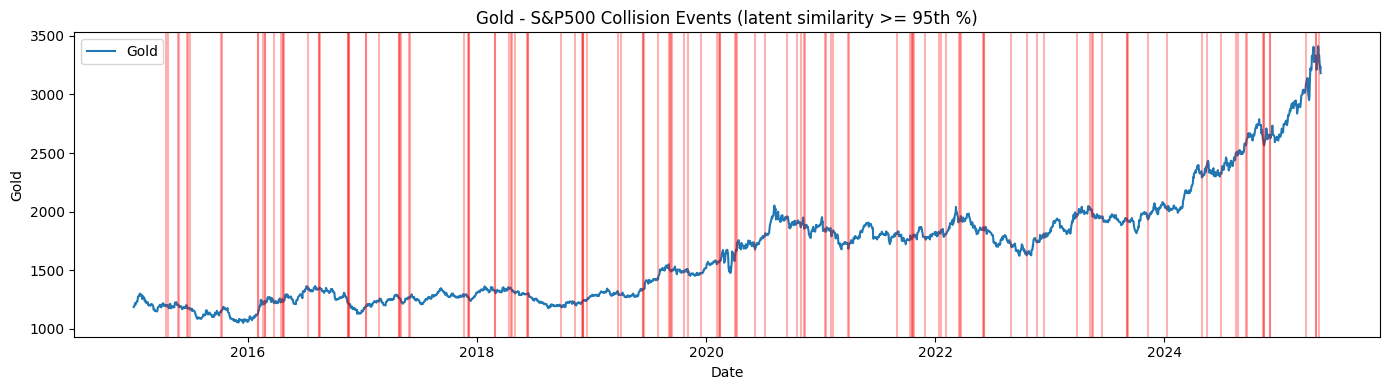

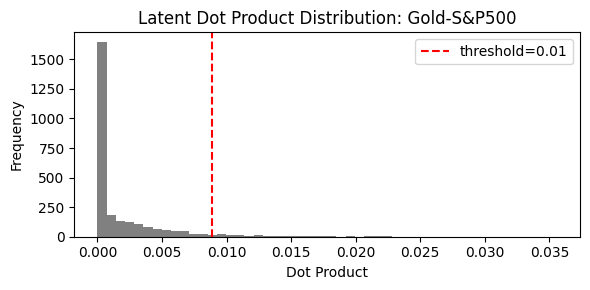

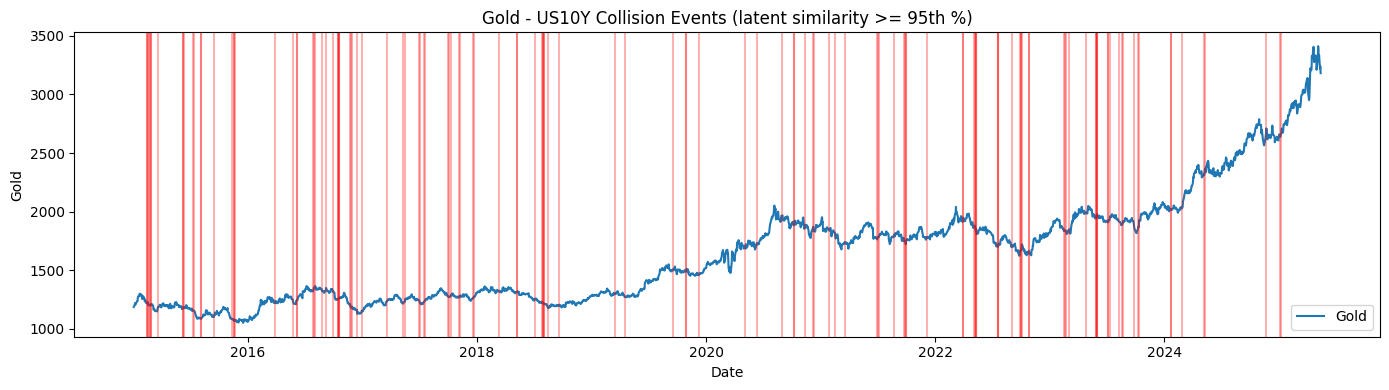

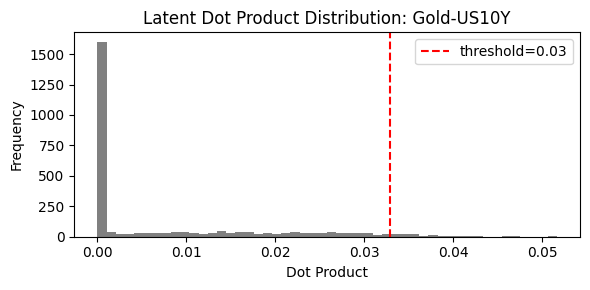

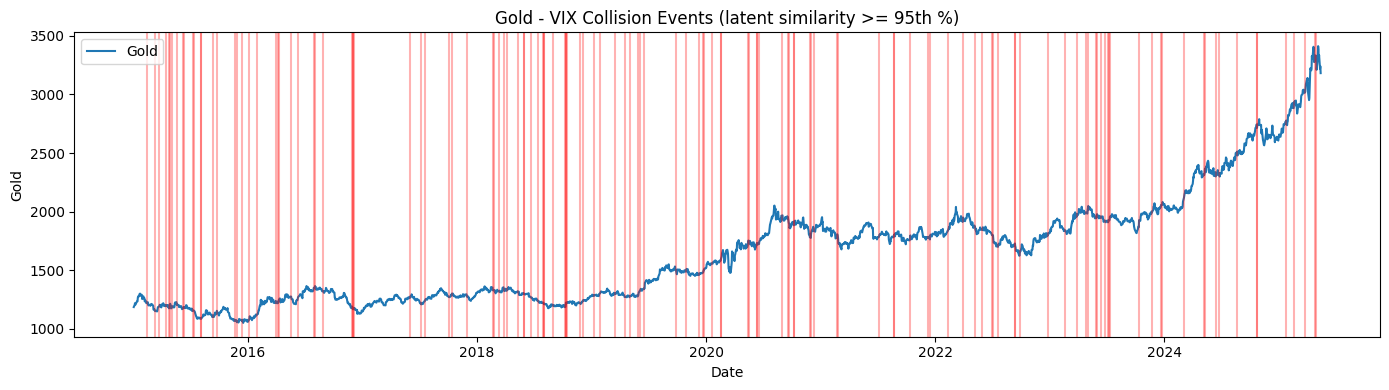

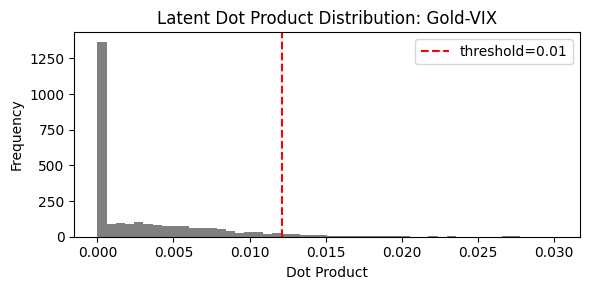

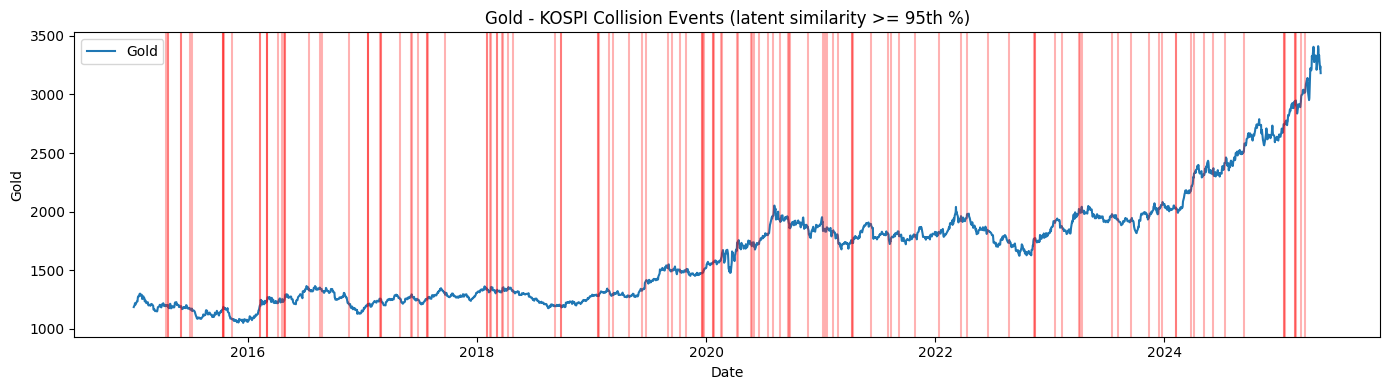

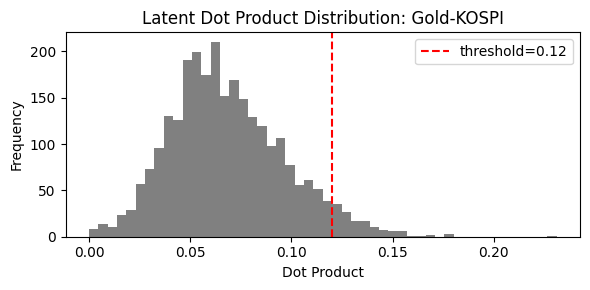

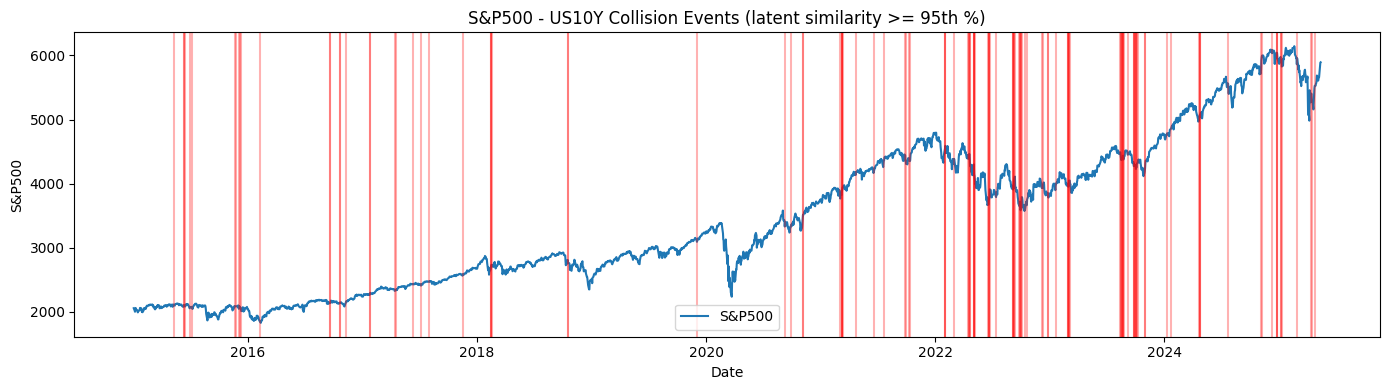

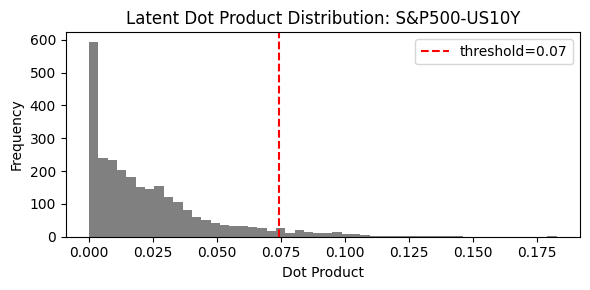

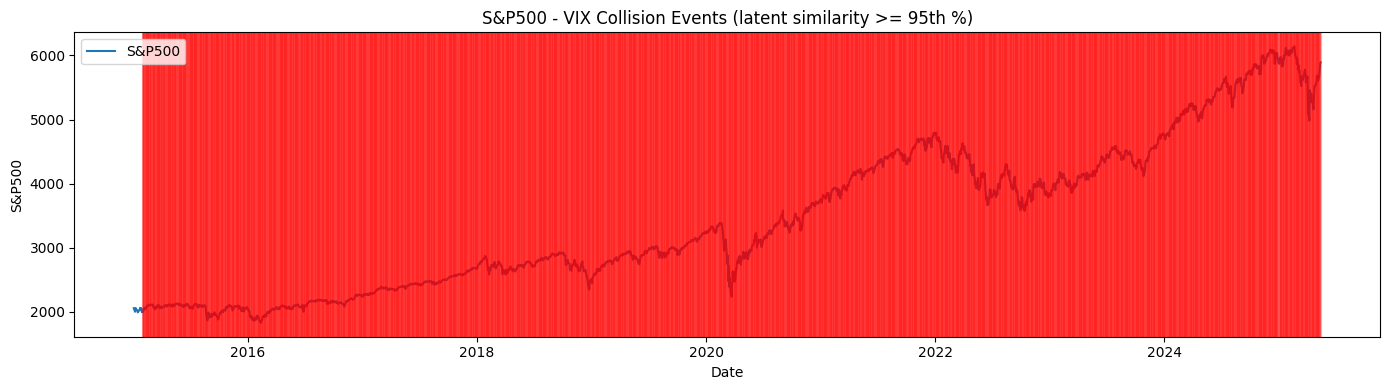

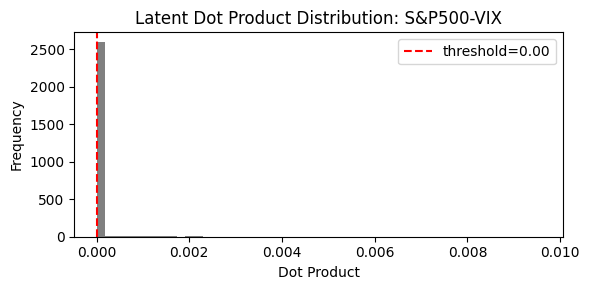

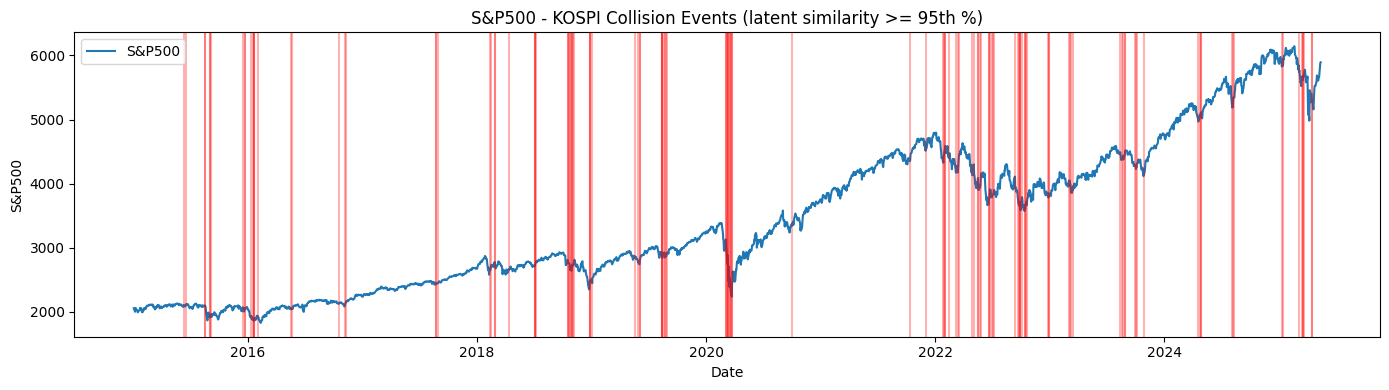

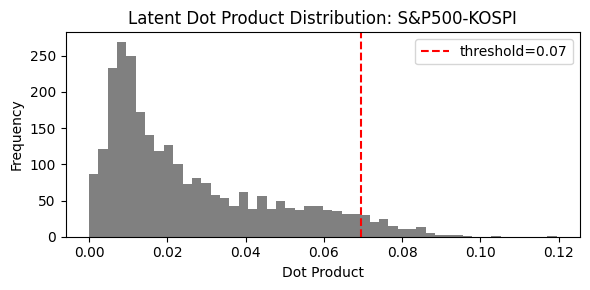

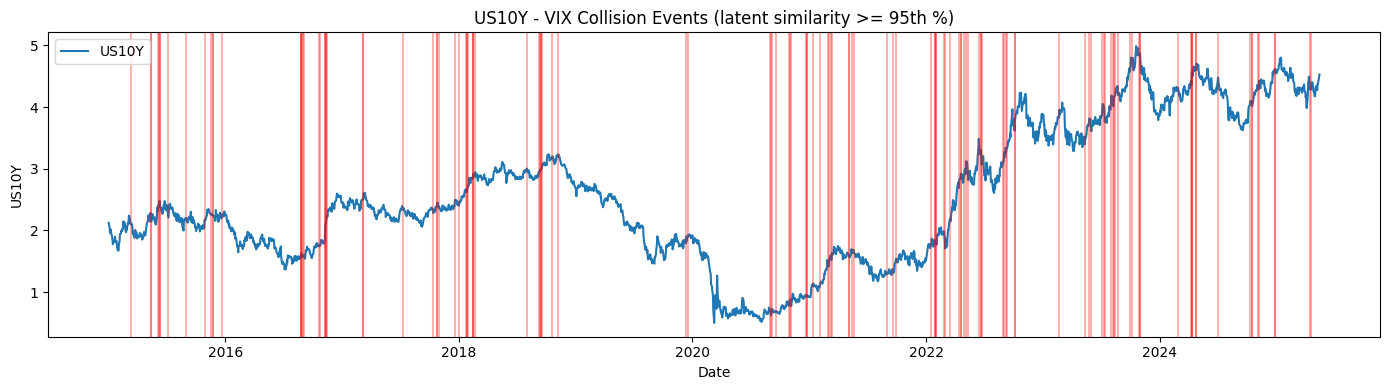

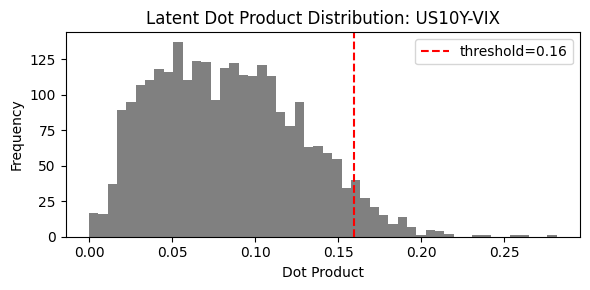

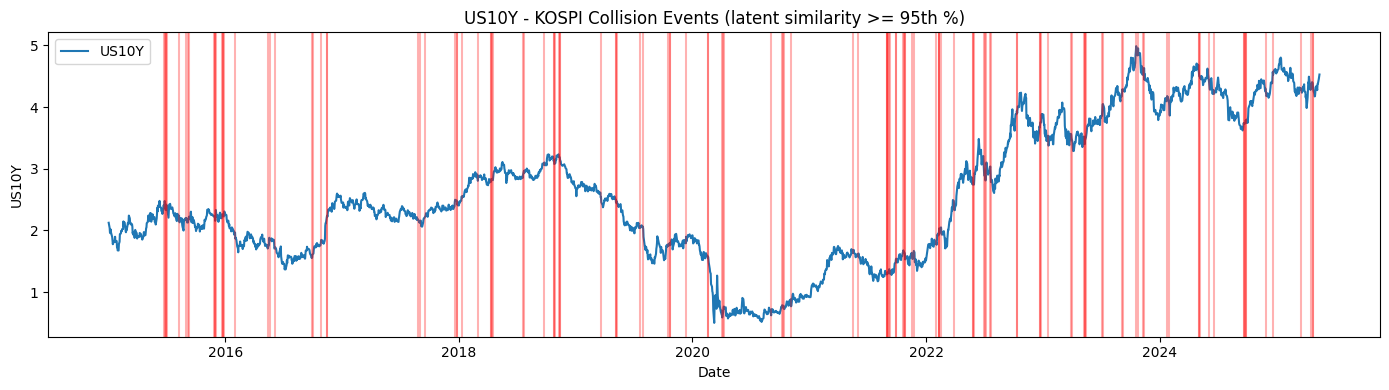

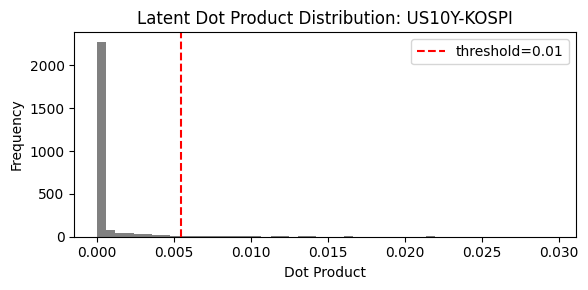

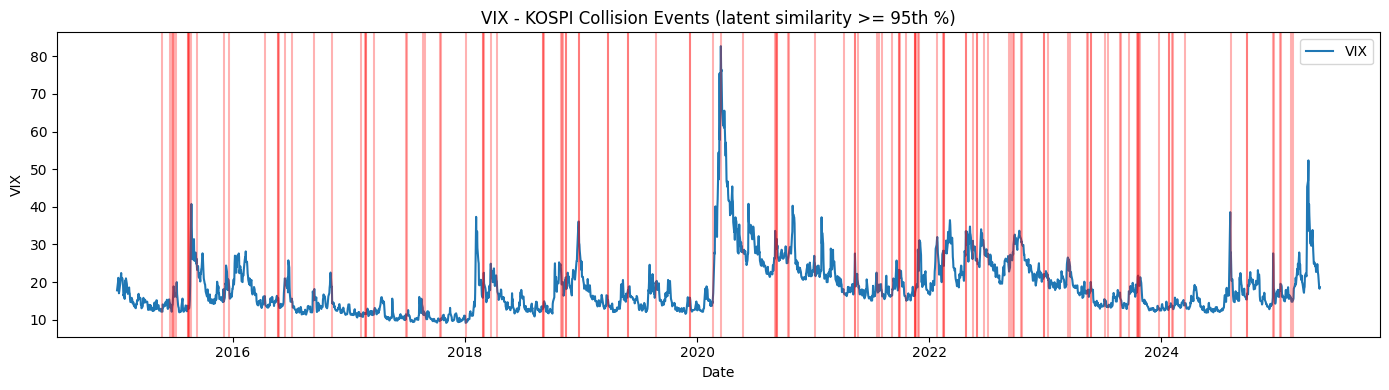

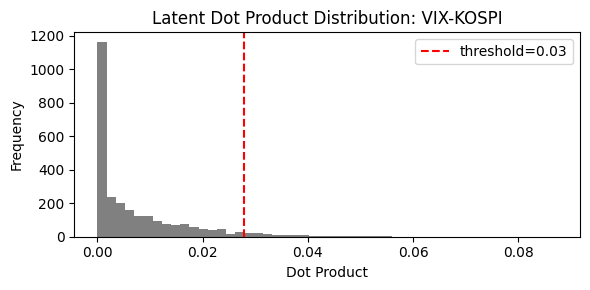

In [ ]:
# 자산 충돌 분석
L = 20
collision_results = []

# 모든 자산쌍 반복
for a1, a2 in itertools.combinations(asset_name, 2):
    # 각 자산 window z-score 벡터 생성
    X1, X2 = [], []
    for i in range(L, len(combined_df)):
        w1 = combined_df[a1].iloc[i-L:i].values
        w2 = combined_df[a2].iloc[i-L:i].values
        X1.append(safe_zscore(w1))
        X2.append(safe_zscore(w2))
    X1 = np.array(X1)
    X2 = np.array(X2)

    # autoencoder 학습
    ae1 = Autoencoder(input_dim=L).to(device)
    ae2 = Autoencoder(input_dim=L).to(device)
    optimizer1 = torch.optim.Adam(ae1.parameters(), lr=1e-3)
    optimizer2 = torch.optim.Adam(ae2.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    X1_tensor = torch.tensor(X1, dtype=torch.float32, device=device)
    X2_tensor = torch.tensor(X2, dtype=torch.float32, device=device)
    for epoch in range(10):
        optimizer1.zero_grad()
        recon1 = ae1(X1_tensor)
        loss1 = loss_fn(recon1, X1_tensor)
        loss1.backward()
        optimizer1.step()

        optimizer2.zero_grad()
        recon2 = ae2(X2_tensor)
        loss2 = loss_fn(recon2, X2_tensor)
        loss2.backward()
        optimizer2.step()

    # latent feature 추출
    latent1 = ae1.encoder(X1_tensor).detach().cpu().numpy()
    latent2 = ae2.encoder(X2_tensor).detach().cpu().numpy()

    # dot product similarity 계산
    dot_sim = (latent1 * latent2).sum(axis=1)
    threshold = np.quantile(dot_sim, 0.95)
    collision_idx = np.where(dot_sim >= threshold)[0]
    collision_dates = combined_df.index[L:][collision_idx]  # index offset 주의!

    collision_results.append({
        'pair': (a1, a2),
        'dot_sim': dot_sim,
        'threshold': threshold,
        'collision_dates': collision_dates
    })

    # 시각화 예시 (각 쌍의 첫 번째 자산 가격 위에 collision 표시)
    plt.figure(figsize=(14,4))
    plt.plot(combined_df.index, combined_df[a1], label=f"{a1}")
    for dt in collision_dates:
        plt.axvline(dt, color='red', alpha=0.3)
    plt.title(f"{a1} - {a2} Collision Events (latent similarity >= 95th %)")
    plt.xlabel('Date')
    plt.ylabel(a1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # dot product 분포도 같이 시각화
    plt.figure(figsize=(6,3))
    plt.hist(dot_sim, bins=50, color='gray')
    plt.axvline(threshold, color='red', linestyle='--', label=f"threshold={threshold:.2f}")
    plt.title(f"Latent Dot Product Distribution: {a1}-{a2}")
    plt.xlabel('Dot Product'); plt.ylabel('Frequency')
    plt.legend(); plt.tight_layout(); plt.show()

In [ ]:

# 1. 실험(trajectory) 개수
N_path = 10
#asset_name = ["WTI", "USD_KRW", "Gold", "SP500", "US10Y", "VIX"]
L = 20
path_ensemble = []  # 모든 경로의 결과 저장

for path_idx in range(N_path):
    collision_results = []
    print("N_path", path_idx)
    # 모든 자산쌍 반복 (하나의 "경로"에 해당)
    for a1, a2 in itertools.combinations(asset_name, 2):
        # 각 자산 window z-score 벡터 생성
        X1, X2 = [], []
        for i in range(L, len(combined_df)):
            w1 = combined_df[a1].iloc[i-L:i].values
            w2 = combined_df[a2].iloc[i-L:i].values
            X1.append(safe_zscore(w1))
            X2.append(safe_zscore(w2))
        X1 = np.array(X1)
        X2 = np.array(X2)

        # Autoencodaer 학습
        ae1 = Autoencoder(input_dim=L).to(device)
        ae2 = Autoencoder(input_dim=L).to(device)
        optimizer1 = torch.optim.Adam(ae1.parameters(), lr=1e-3)
        optimizer2 = torch.optim.Adam(ae2.parameters(), lr=1e-3)
        loss_fn = torch.nn.MSELoss()
        X1_tensor = torch.tensor(X1, dtype=torch.float32, device=device)
        X2_tensor = torch.tensor(X2, dtype=torch.float32, device=device)
        for epoch in range(200):
            optimizer1.zero_grad()
            recon1 = ae1(X1_tensor)
            loss1 = loss_fn(recon1, X1_tensor)
            loss1.backward()
            optimizer1.step()

            optimizer2.zero_grad()
            recon2 = ae2(X2_tensor)
            loss2 = loss_fn(recon2, X2_tensor)
            loss2.backward()
            optimizer2.step()

        # latent/dot_sim/collision 기록
        latent1 = ae1.encoder(X1_tensor).detach().cpu().numpy()
        latent2 = ae2.encoder(X2_tensor).detach().cpu().numpy()
        dot_sim = (latent1 * latent2).sum(axis=1)
        threshold = np.quantile(dot_sim, 0.92)
        collision_idx = np.where(dot_sim >= threshold)[0]
        collision_dates = combined_df.index[L:][collision_idx]
        collision_results.append({
            'pair': (a1, a2),
            'dot_sim': dot_sim,
            'threshold': threshold,
            'collision_dates': set(collision_dates)
        })


    # 각 실험 경로별 결과를 저장
    path_ensemble.append(collision_results)

# 각 쌍별로, 모든 경로에서 collision이 등장한 날짜의 빈도 구하기
collision_counter_by_pair = {pair: collections.Counter() for pair in itertools.combinations(asset_name, 2)}
for trajectory in path_ensemble:
    for res in trajectory:
        pair = res['pair']
        collision_counter_by_pair[pair].update(res['collision_dates'])

# 각 날짜별 collision 발생 확률 계산
collision_prob_by_pair = {pair: {} for pair in collision_counter_by_pair}
for pair, counter in collision_counter_by_pair.items():
    total_paths = N_path
    for dt, cnt in counter.items():
        collision_prob_by_pair[pair][dt] = cnt / total_paths  # 확률



N_path 0
N_path 1
N_path 2
N_path 3
N_path 4
N_path 5
N_path 6
N_path 7
N_path 8
N_path 9


<ipython-input-67-46c7316f79d5>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', 15)
<ipython-input-67-46c7316f79d5>:12: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(prob_dates, yvals, color=colors(i), marker=markers[i], s=110, edgecolor='k',
<ipython-input-67-46c7316f79d5>:12: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(prob_dates, yvals, color=colors(i), marker=markers[i], s=110, edgecolor='k',
<ipython-input-67-46c7316f79d5>:12: UserWarning: You passed a edgecolor/edg

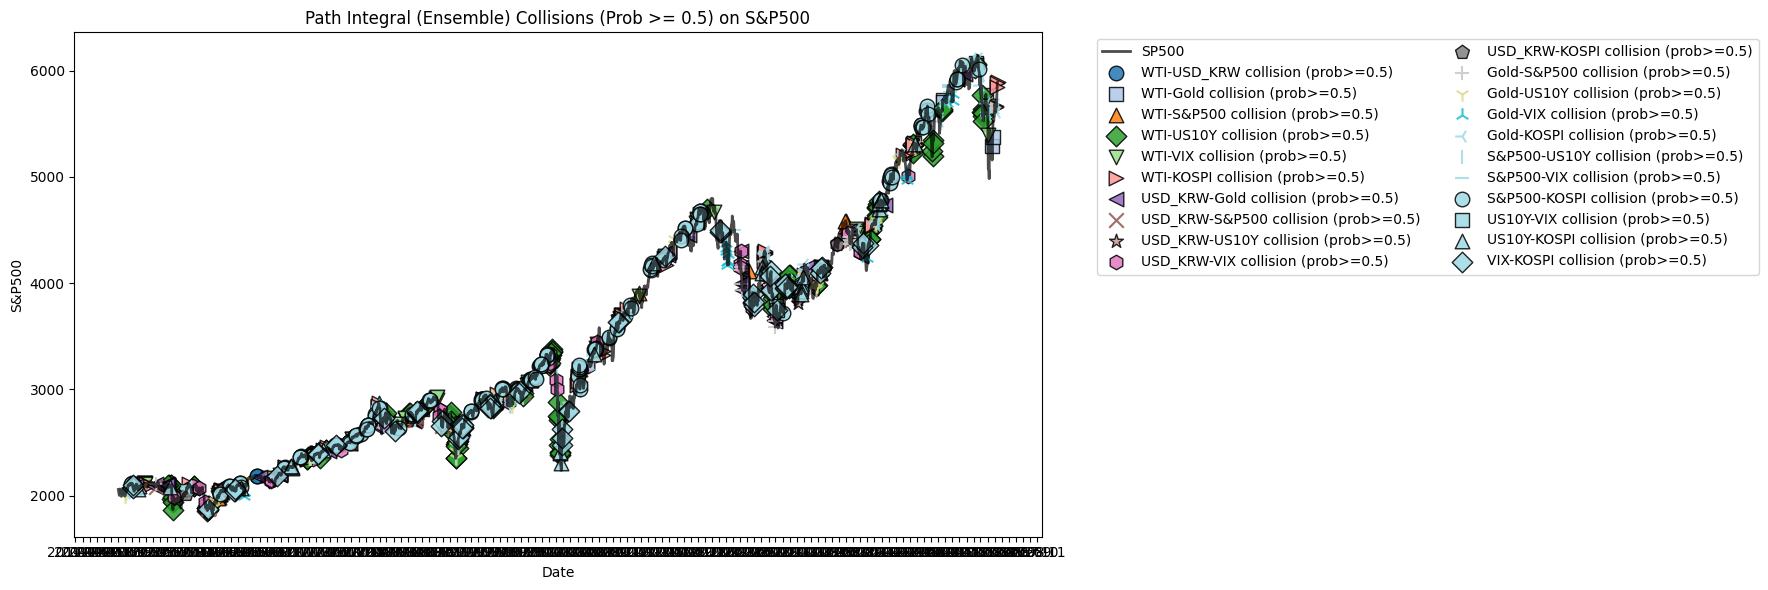

In [ ]:
# S&P500 위에, collision 확률이 0.5 이상인 날만 표시
plt.figure(figsize=(18, 6))
plt.plot(combined_df.index, combined_df["S&P500"], label="SP500", color="black", linewidth=2, alpha=0.7)

colors = cm.get_cmap('tab20', 15)
markers = ['o', 's', '^', 'D', 'v', '>', '<', 'x', '*', 'h', 'p', '+', '1', '2', '3', '|', '_'] * 2
for i, pair in enumerate(collision_prob_by_pair.keys()):
    prob_dates = [dt for dt, prob in collision_prob_by_pair[pair].items() if prob >= 0.5]
    yvals = combined_df.loc[prob_dates, "S&P500"]
    if len(prob_dates) == 0:
        continue
    plt.scatter(prob_dates, yvals, color=colors(i), marker=markers[i], s=110, edgecolor='k',
                label=f"{pair[0]}-{pair[1]} collision (prob>=0.5)", alpha=0.85)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title("Path Integral (Ensemble) Collisions (Prob >= 0.5) on S&P500")
plt.xlabel("Date")
plt.ylabel("S&P500")
plt.legend(ncol=2, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-68-954491c13202>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', 15)
<ipython-input-68-954491c13202>:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(prob_dates, yvals, color=colors(i), marker=markers[i], s=110, edgecolor='k',
<ipython-input-68-954491c13202>:17: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('3').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(prob_dates, yvals, color=colors(i), marker=markers[i], s=110, edgecolor='k',
<ipython-input-68-954491c13202>:17: UserWarning: You passed a edgecolor/edg

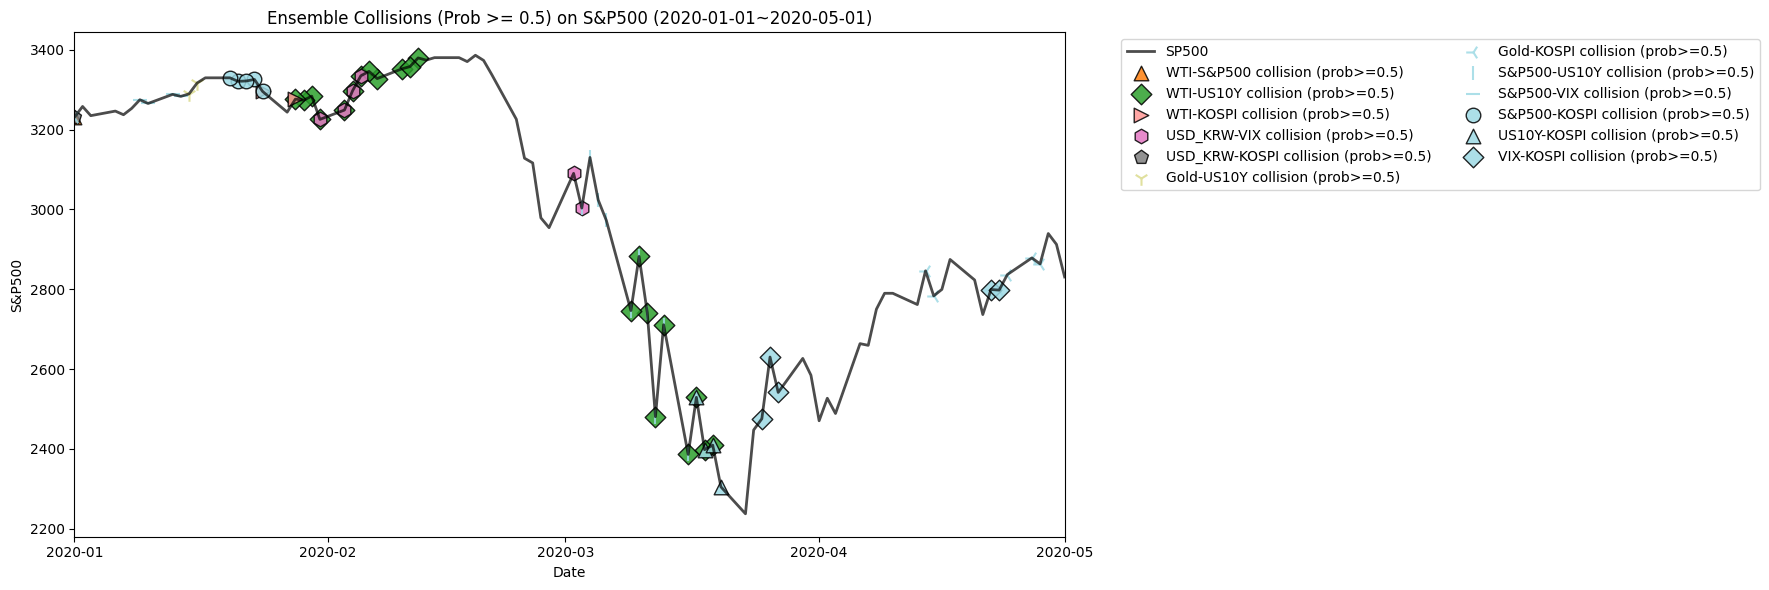

In [ ]:
start_zoom = pd.Timestamp("2020-01-01")
end_zoom = pd.Timestamp("2020-05-01")

plt.figure(figsize=(18, 6))
sp500_zoom = combined_df["S&P500"].loc[start_zoom:end_zoom]
plt.plot(sp500_zoom.index, sp500_zoom, label="SP500", color="black", linewidth=2, alpha=0.7)

colors = cm.get_cmap('tab20', 15)
markers = ['o', 's', '^', 'D', 'v', '>', '<', 'x', '*', 'h', 'p', '+', '1', '2', '3', '|', '_'] * 2

for i, pair in enumerate(collision_prob_by_pair.keys()):
    prob_dates = [dt for dt, prob in collision_prob_by_pair[pair].items()
                  if prob >= 0.5 and (start_zoom <= dt <= end_zoom)]
    yvals = combined_df.loc[prob_dates, "S&P500"] if len(prob_dates) > 0 else []
    if len(prob_dates) == 0:
        continue
    plt.scatter(prob_dates, yvals, color=colors(i), marker=markers[i], s=110, edgecolor='k',
                label=f"{pair[0]}-{pair[1]} collision (prob>=0.5)", alpha=0.85)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlim(start_zoom, end_zoom)
plt.title(f"Ensemble Collisions (Prob >= 0.5) on S&P500 ({start_zoom.date()}~{end_zoom.date()})")
plt.xlabel("Date")
plt.ylabel("S&P500")
plt.legend(ncol=2, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

